<div>
<img src="https://www.nasa.gov/wp-content/uploads/2024/07/osdr-gl4hs-logo.png" width="600"/>
</div>

# **NOTEBOOK 7: Performing gene set enrichment analysis (GSEA) and over-representation analysis (ORA)**
In this notebook, you will run statistical tests to determine which gene sets are over-represented by the differentially expressed genes you identified in the previous notebook. You'll also conduct gene set enrichment analysis which uses the gene expression data itself to determine which gene sets are enriched by genes differentially expressed between 2 groups (in this case, spaceflight and ground control).

## **Objectives of this notebook**
The primary objective of this notebook is to use Python's gseapy implementations of GSEA and ORA to find gene sets which are statistically significantly enriched by the genes that are differentially expressed between ground control and space flight groups in OSD-104.

GSEA and ORA help us better understand which biological, cellular, and molecular processes and pathways explain the phenotypic differences we may observe between space flight and ground control mice. By extension, because the mouse is a model organism with many orthologous genes to humans, we may infer how spaceflight may impact astronaut health. You can read more about GSEA in this [Wikipedia article](https://en.wikipedia.org/wiki/Gene_set_enrichment_analysis).

We use a library called enrichR which is written for R, Python, and has an [online portal](https://maayanlab.cloud/Enrichr/) you can query. You can learn more about enrichR and gene set enrichment analysis in this [YouTube video](https://www.youtube.com/watch?v=H1cUs6pql9s). The `gseapy` Python module has implementations for both GSEA as well as ORA. The major difference between these 2 approaches is that GSEA takes gene expression data as input and ORA takes a list of genes as input. As such, ORA is a more flexible tool and can be used to find gene sets and pathways that enriched by a list of genes regardless of how that list is derived. Here is a [Website](https://rnabio.org/module-08-scrna/0008/05/01/Gene_set_enrichment/) which discusses the differences between these 2 approaches.

## **UNIX commands introduced in this notebook**

N/A

# Prepare the runtime environment for the notebook

In [1]:
# mount google drive
from google.colab import drive
drive.flush_and_unmount()
drive.mount("mnt")

Drive not mounted, so nothing to flush and unmount.
Mounted at mnt


In [2]:
# time the notebook
import datetime
start_time = datetime.datetime.now()
print('notebook start time: ', start_time.strftime('%Y-%m-%d %H:%M:%S'))

notebook start time:  2025-07-16 19:48:24


In [3]:
# define OSD dataset number to use for this notebook
OSD_DATASET='104'
GLDS_DATASET='104'

In [4]:
# set DGEA_DIR to get DEGs
import os
DGEA_DIR="/content/mnt/MyDrive/NASA/GL4HS/DGEA/" + OSD_DATASET
if not os.path.exists(DGEA_DIR):
  raise Exception("STOP! You must finish the preceding notebook before running this one")

In [5]:
import os
GSEA_DIR="/content/mnt/MyDrive/NASA/GL4HS/GSEA/" + OSD_DATASET
if not os.path.exists(GSEA_DIR):
  !mkdir -p {GSEA_DIR}

In [6]:
import os
META_DIR="/content/mnt/MyDrive/NASA/GL4HS/META/" + OSD_DATASET
if not os.path.exists(META_DIR):
  raise Exception("STOP! You must finish the preceding notebook before running this one")

In [7]:
# install packages and import the modules needed to do DGEA
!pip install gseapy==1.1.8 --no-cache
#gseapy = geneset enrichment analysis (python)
import gseapy as gp
from gseapy import Msigdb
!pip install mygene

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.4 MB/s eta 0:00:00


# Define Python methods

In [8]:
# define method to run ORA
def run_ora( gene_results, gene_set_list, background_genes=[], display_cols=['Term', 'Genes', 'Adjusted P-value', 'Combined Score'], sleep_time=5, retries=10):
  counter = 0
  import time
  enr = None
  gsea = None
  while counter < retries:
    try:
      # use enrichR to get gene ontology terms for molecular function, cellular components, and biological processes
      # sometimes the call fails, so just re-run the cell after a few seconds
      enr = gp.enrichr(gene_list=list(gene_results),
                      gene_sets=gene_set_list,
                      organism='mouse',
                      outdir=None,
                      )
    except:
      time.sleep(sleep_time)
      counter += 1
      continue
    break

  if not enr is None:
    # show top 10 results with adjusted p-value less than 0.05
    # other cols to display ['Term', 'Overlap', 'Genes', 'Adjusted P-value']
    gsea = enr.results[enr.results['Adjusted P-value'] < 0.05][display_cols]
  else:
    print('gsea failed')
  return gsea, enr

In [9]:
# define method to run gseapy
def run_run_ora(deg_gene_symbols, background_gene_symbols, available_gene_sets, gene_set_list):
  gene_sets = list()
  for gene_set in gene_set_list:
    if gene_set not in available_gene_sets:
      print('gene set NOT found: ', gene_set)
    else:
      print('gene set found: ', gene_set)
      gene_sets.append(gene_set)
  results, enr = run_ora(deg_gene_symbols, gene_sets, background_gene_symbols)

  return results, enr

In [10]:
# define method to convert gene ids to symbols
def get_symbols_from_ids(gene_ids):
  import mygene

  mg = mygene.MyGeneInfo()

  results = mg.querymany(gene_ids, scopes="ensembl.gene", fields="symbol")

  gene_symbols = list()

  for res in results:
      if "symbol" in res:
        gene_symbols.append(res['symbol'])
      else:
        gene_symbols.append(res['query'])

  return gene_symbols

# Read in data from google drive

In [11]:
# read DEGs from file
import os
degs = []
file_path = os.path.join(DGEA_DIR, 'deg_genes-' + OSD_DATASET + '.txt')
if not os.path.exists(file_path):
  raise Exception("STOP! You must finish the preceding notebook before running this one")
with open(file_path, 'r') as f:
  for line in f:
    degs.append(line.strip())

In [12]:
# print the first 10 degs
print('number of DEGs: ', len(degs))
degs[:10]

number of DEGs:  159


['ENSMUSG00000000308',
 'ENSMUSG00000000567',
 'ENSMUSG00000001510',
 'ENSMUSG00000002910',
 'ENSMUSG00000006576',
 'ENSMUSG00000015090',
 'ENSMUSG00000015401',
 'ENSMUSG00000015599',
 'ENSMUSG00000016179',
 'ENSMUSG00000018486']

These genes are Ensembl gene IDs. You can learn more about Ensembl gene IDs [here](https://useast.ensembl.org/info/genome/stable_ids/index.html).

In [13]:
# convert gene ids to symbols and print the first 10
deg_gene_symbols = get_symbols_from_ids(degs)
deg_gene_symbols[:10]

INFO:biothings.client:querying 1-159 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


['Ckmt1',
 'Sox9',
 'Dlx3',
 'Arrdc2',
 'Slc4a3',
 'Ptgds',
 'Cltrn',
 'Ttbk1',
 'Camk1g',
 'Wnt9b']

These genes are Ensembl gene symbols. You can learn more about Ensembl gene naming [here](https://www.informatics.jax.org/mgihome/nomen/gene.shtml).


In [14]:
# write DEG gene symbols to file
import os
file_path = os.path.join(DGEA_DIR, 'deg_gene_symbols-' + OSD_DATASET + '.txt')
with open(file_path, 'w') as f:
  for gene in deg_gene_symbols:
    f.write(gene + '\n')

We are going to submit the list of "background" genes along with the differentially expressed genes to the gseapy Enrichr tool. You can read more about background genes on this [biostars thread](https://www.biostars.org/p/17628/).

In [15]:
# read background genes from file
background_genes = []
import os
file_path = os.path.join(DGEA_DIR, 'background_genes-' + OSD_DATASET + '.txt')
if not os.path.exists(file_path):
  raise Exception("STOP! You must finish the preceding notebook before running this one")
with open(file_path, 'r') as f:
  for line in f:
    background_genes.append(line.strip())

In [16]:
# print the first 10 background genes
print('number of background genes: ', len(background_genes))
background_genes[:10]

number of background genes:  2104


['ENSMUSG00000000049',
 'ENSMUSG00000000167',
 'ENSMUSG00000000204',
 'ENSMUSG00000000214',
 'ENSMUSG00000000247',
 'ENSMUSG00000000303',
 'ENSMUSG00000000308',
 'ENSMUSG00000000385',
 'ENSMUSG00000000386',
 'ENSMUSG00000000409']

In [17]:
# convert gene ids to symbols and print the first 10
background_gene_symbols = get_symbols_from_ids(background_genes)
background_gene_symbols[:10]

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-2104 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


['Apoh',
 'Pih1d2',
 'Slfn4',
 'Th',
 'Lhx2',
 'Cdh1',
 'Ckmt1',
 'Tmprss2',
 'Mx1',
 'Lck']

In [18]:
# write the background gene symbols to file
with open(DGEA_DIR + '/background_gene_symbols-' + OSD_DATASET + '.txt', 'w') as f:
  for gene in background_genes:
    f.write(gene + '\n')

# Run gene set enrichment analysis
We will use gsea from the gseapy Python package to perform gene set enrichment analysis. The code in this section was drived from [this example](https://gseapy.readthedocs.io/en/latest/gseapy_example.html#GSEA-Example) in the gseapy documentation.

In [19]:
# read in expr_df from google drive
import pandas as pd
expr_df = pd.read_csv(DGEA_DIR + '/expr_df.csv')

# get list of genes from data frame
genes=list(expr_df['Unnamed: 0'])

# convert gene ids to gene symbols
gene_symbols = get_symbols_from_ids(genes)

# then cast gene names to upper case
gene_symbols_upper = [gene.upper() for gene in gene_symbols]
expr_df['Unnamed: 0'] = gene_symbols_upper

# print first 5 rows of expression matrix
expr_df.head()


INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-2104 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,Unnamed: 0,Mmus_C57-6J_SLS_FLT_Rep1_M23,Mmus_C57-6J_SLS_FLT_Rep2_M24,Mmus_C57-6J_SLS_FLT_Rep3_M25,Mmus_C57-6J_SLS_FLT_Rep4_M26,Mmus_C57-6J_SLS_FLT_Rep5_M27,Mmus_C57-6J_SLS_FLT_Rep6_M28,Mmus_C57-6J_SLS_GC_Rep1_M33,Mmus_C57-6J_SLS_GC_Rep2_M34,Mmus_C57-6J_SLS_GC_Rep3_M35,Mmus_C57-6J_SLS_GC_Rep4_M36,Mmus_C57-6J_SLS_GC_Rep5_M37,Mmus_C57-6J_SLS_GC_Rep6_M38
0,APOH,11.0,11.0,23.0,18.0,66.0,10.0,13.0,9.0,12.0,8.0,15.0,12.0
1,PIH1D2,15.0,3.0,5.0,3.0,5.0,8.0,18.0,6.0,12.0,11.0,10.0,6.0
2,SLFN4,0.0,3.0,4.0,8.0,18.0,2.0,2.0,0.0,5.0,23.0,1.0,5.0
3,TH,6.0,37.0,16.0,12.0,16.0,7.0,15.0,7.0,13.0,6.0,25.0,10.0
4,LHX2,7.0,12.0,10.0,20.0,12.0,1.0,22.0,7.0,10.0,14.0,11.0,6.0


Note that the column containing the genes is called `Unnamed: 0`. This is a name given by the pandas library to the first column in a column-separated or tab-separated value file which doesn't have a name.

In [20]:
# get metadata from file that was written in previous notebook

import pandas as pd
meta_df = pd.read_csv(f"{META_DIR}/s_OSD-" + OSD_DATASET + ".txt", sep='\t')

# create list of classes for samples
classes = list(meta_df['Factor Value[Spaceflight]'])
print(classes[:10])

['Ground Control', 'Ground Control', 'Ground Control', 'Ground Control', 'Ground Control', 'Ground Control', 'Space Flight', 'Space Flight', 'Space Flight', 'Space Flight']


There should be 6 samples from the `Ground Control` group and 6 samples from the `Space Flight` group.

In [21]:
# define gene sets to explore in GSEA
go_gene_sets = ['GO_Molecular_Function_2025', \
                 'GO_Biological_Process_2025', \
                 'GO_Cellular_Component_2025']

# run GSEA experiment
go_gsea_res = gp.gsea(data=expr_df,
                 gene_sets=go_gene_sets,
                 cls= classes,
                 # set permutation_type to phenotype if samples >=15
                 outdir=None,
                 method='signal_to_noise',
                 threads=2, seed= 7)

# filter results based on FWER p-val < 0.05
go_gsea_results = go_gsea_res.res2d[go_gsea_res.res2d['FWER p-val'] < 0.05]

# define columns to display in output
display_cols = ['Term', 'Lead_genes', 'NES', 'FWER p-val']

# print top 10 GSEA results
go_gsea_results[display_cols].head(10)

# ssave the GO GSEA results to google drive
go_gsea_results.to_csv(GSEA_DIR + '/go_gsea_results_' + OSD_DATASET + '.csv', index=None)


There are 3 gene ontology (GO) gene sets in the database, and we're querying all of them. We're passing the `expr_df` expression matrix, list of GO gene sets, and the classes (FLT vs GC) to the `gsea()` method. We are keeping only those results with a family-wise error rate (FWER) p-value less than 0.05. FWER is another technique alongside Benjamini-Hochberg and Bonferroni for adjusting p-values to correct for the multiple-testing problem. You can read more about FWER in [this Wikipedia article](https://en.wikipedia.org/wiki/Family-wise_error_rate).

Note in this case, while we requested the top 10 rows of the results, we only got 3 which indicates that only 3 gene sets were enriched with a FWER-adjusted p-value less than 0.05.

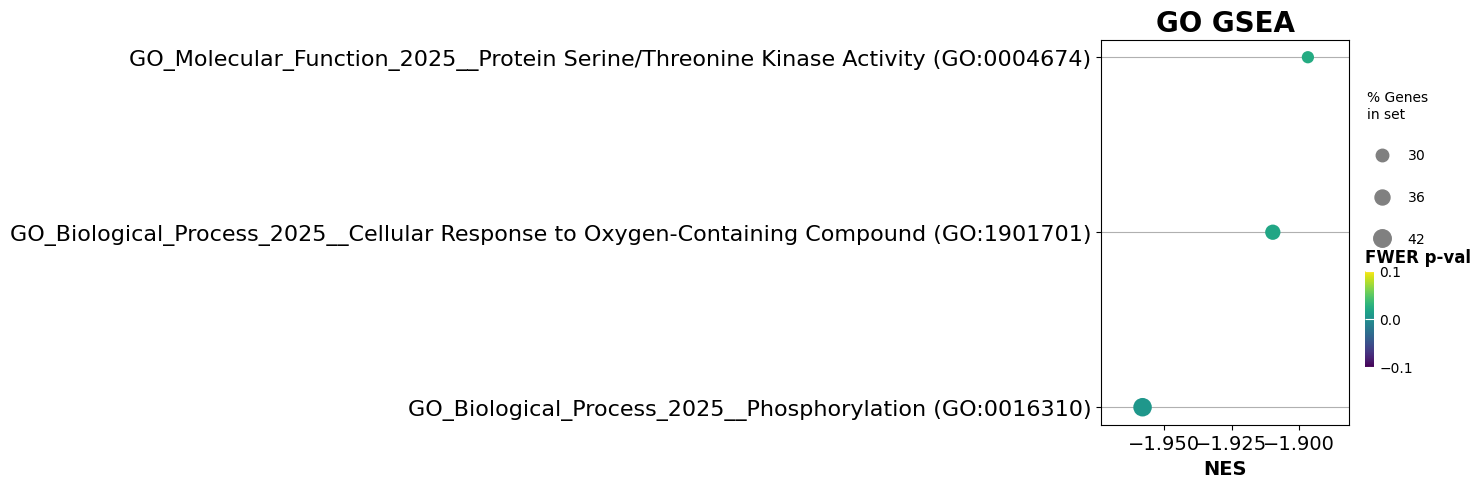

In [22]:
# plot GO GSEA results in dot plot
from gseapy import dotplot
import matplotlib.pyplot as plt
ax = dotplot(go_gsea_results,
             column="FWER p-val",
             title='GO GSEA',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

The smaller the FWER p-value, the more significant the statistical enrichment. The higher the percentage of genes in the gene set, the larger the dot in the plot. The horizontal axis is the normalized enrichment score (NES).

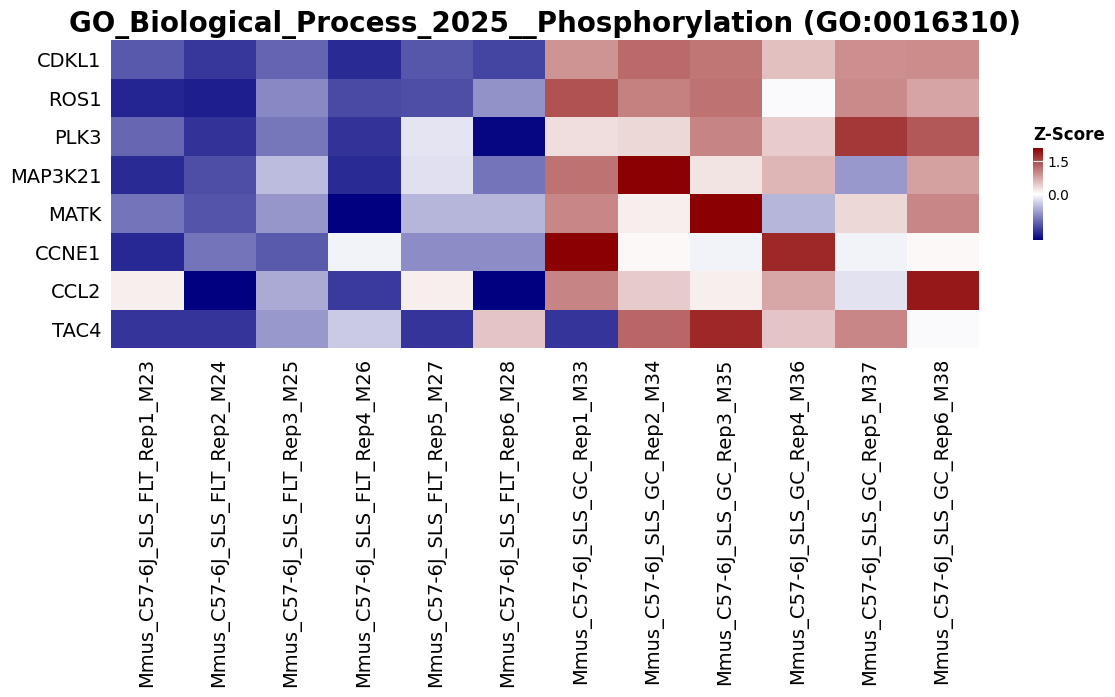

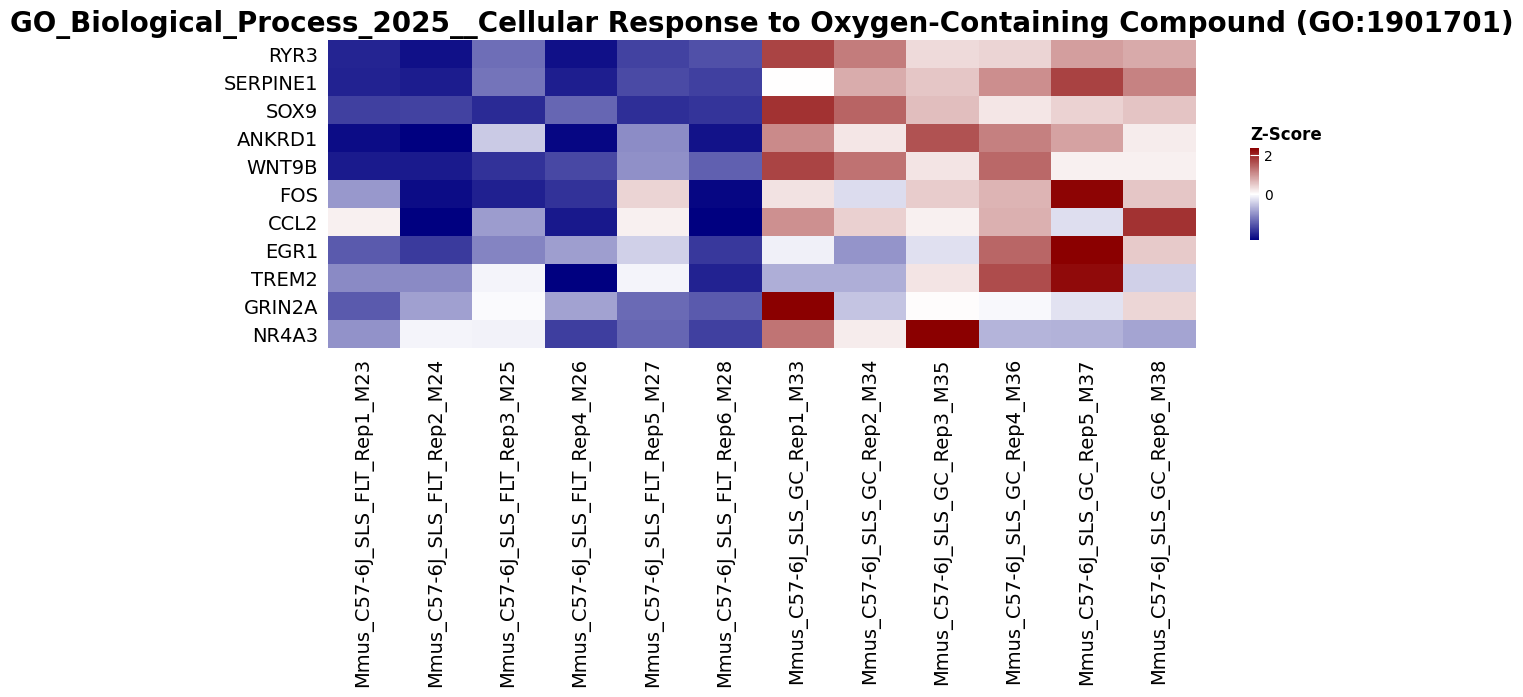

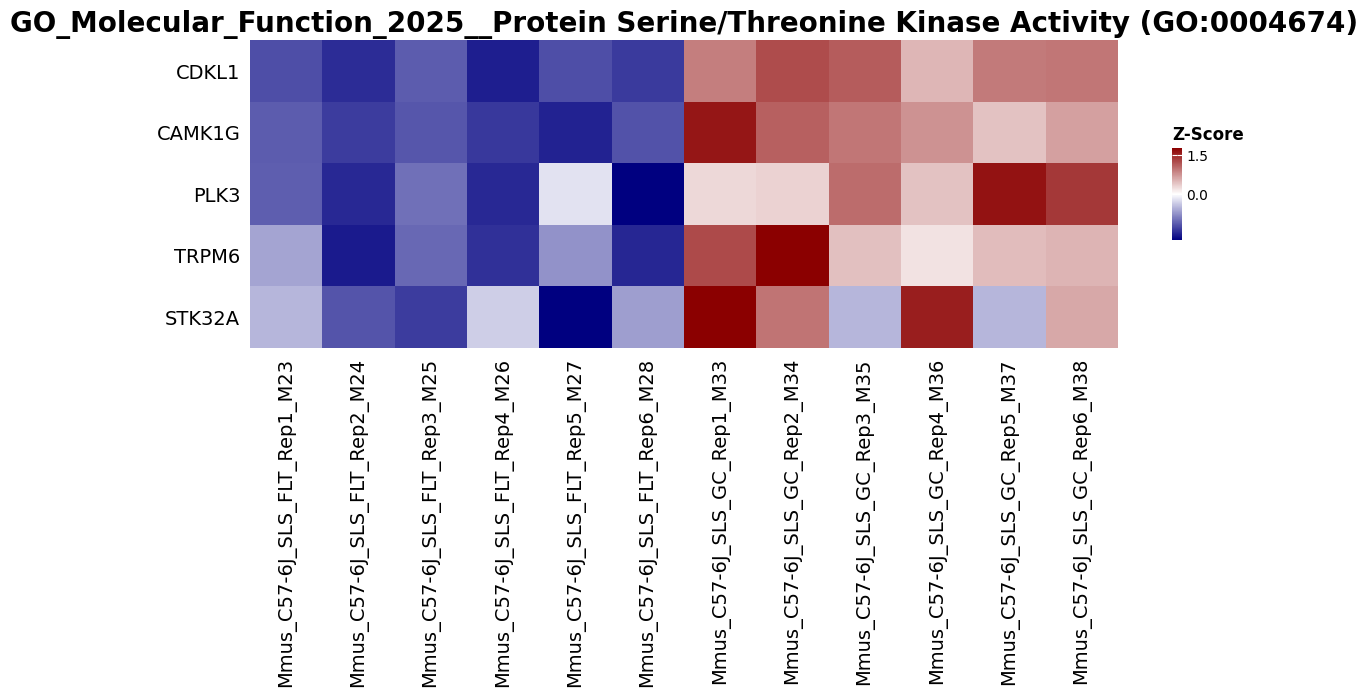

In [23]:
# plot GO GSEA results in heatmap
from gseapy import heatmap
terms = go_gsea_results.Term

for i in range(len(go_gsea_results)):
  genes = go_gsea_results.Lead_genes[i].split(";")
  ax = heatmap(df = go_gsea_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4))

This heatmap uses colors from blue ("cold") to red ("hot"), where cold implies low gene expression and hot implies high gene expression. The difference between the FLT and GC samples is very evident in the plot.

In [24]:
geo_gene_sets = ['Disease_Perturbations_from_GEO_down', \
                 'Disease_Perturbations_from_GEO_up']

geo_gsea_res = gp.gsea(data=expr_df,
                 gene_sets=geo_gene_sets,
                 cls= classes,
                 # set permutation_type to phenotype if samples >=15
                 outdir=None,
                 method='signal_to_noise',
                 threads=2, seed= 7)

# filter results based on FWER p-val
geo_gsea_results = geo_gsea_res.res2d[geo_gsea_res.res2d['FWER p-val'] < 0.05]

# define columns to display in output
display_cols = ['Term', 'Lead_genes', 'NES', 'FWER p-val']

# print top 10 GSEA results
geo_gsea_results[display_cols].head(10)

# save the GEO GSEA results to google drive
geo_gsea_results.to_csv(GSEA_DIR + '/geo_gsea_results_' + OSD_DATASET + '.csv', index=None)

There are 2 gene expression omnibus (GEO) gene sets in the database, and we're querying both of them. We're passing the `expr_df` expression matrix, list of GEO gene sets, and the classes (FLT vs GC) to the `gsea()` method.  The normalized enrichment score (NES) is the de facto metric to use when sorting results, all of which are statistically significant with FWER p-values less than 0.05. You can read more about the normalized enrichment score [here](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideTEXT.htm#_Normalized_Enrichment_Score).

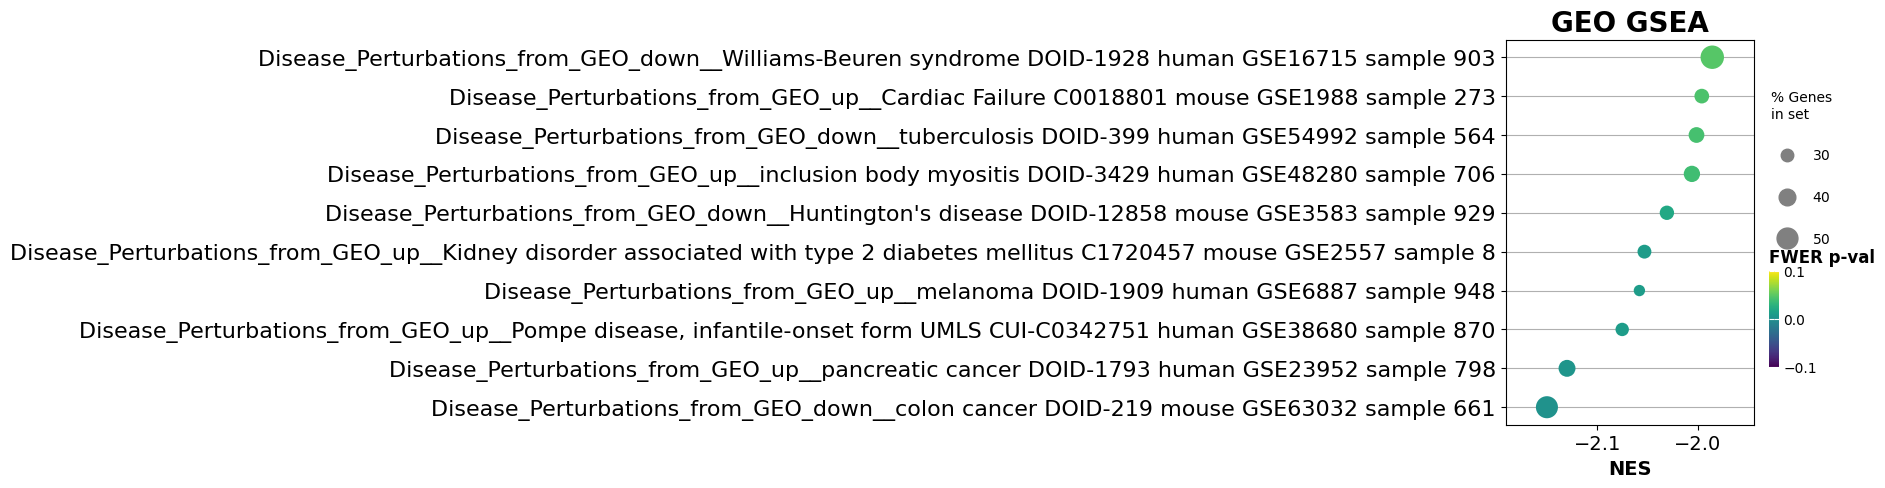

In [25]:
# create the dot plot
from gseapy import dotplot
import matplotlib.pyplot as plt
ax = dotplot(geo_gsea_results,
             column="FWER p-val",
             title='GEO GSEA',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

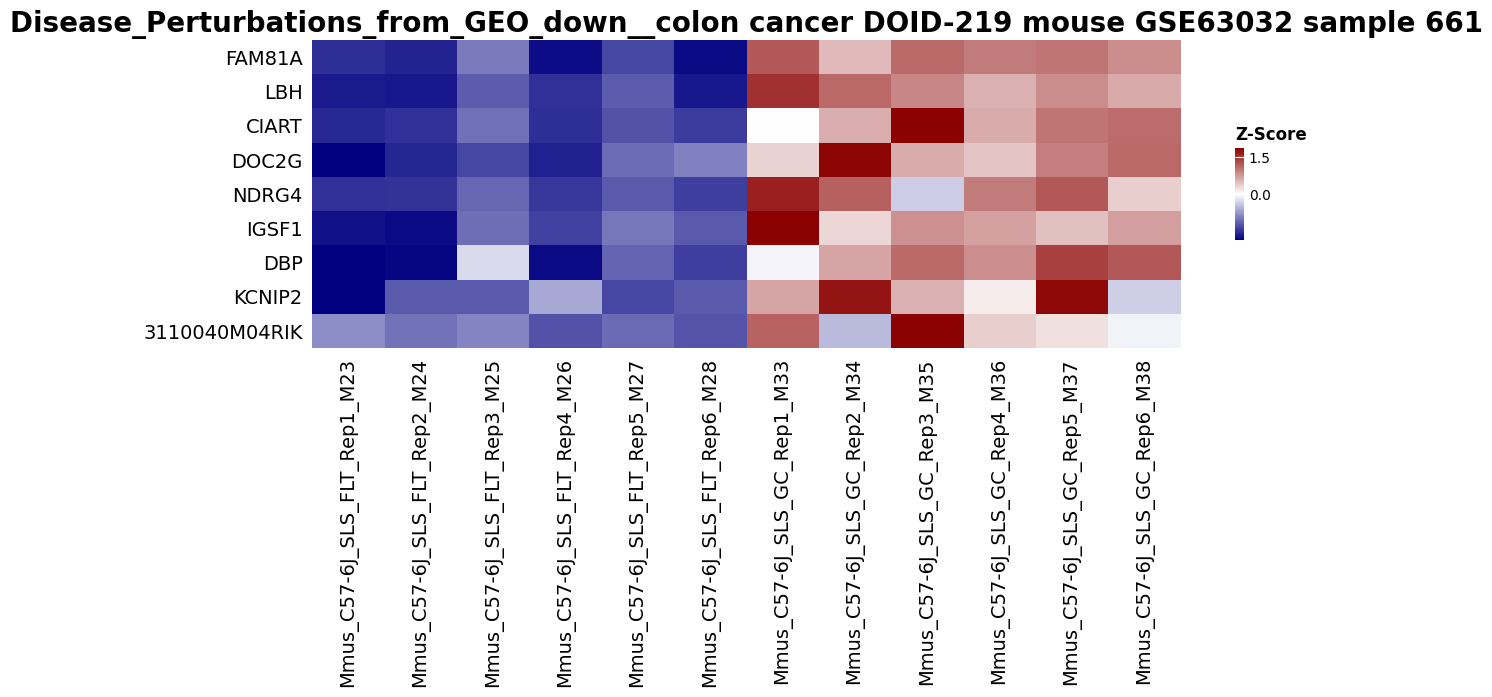

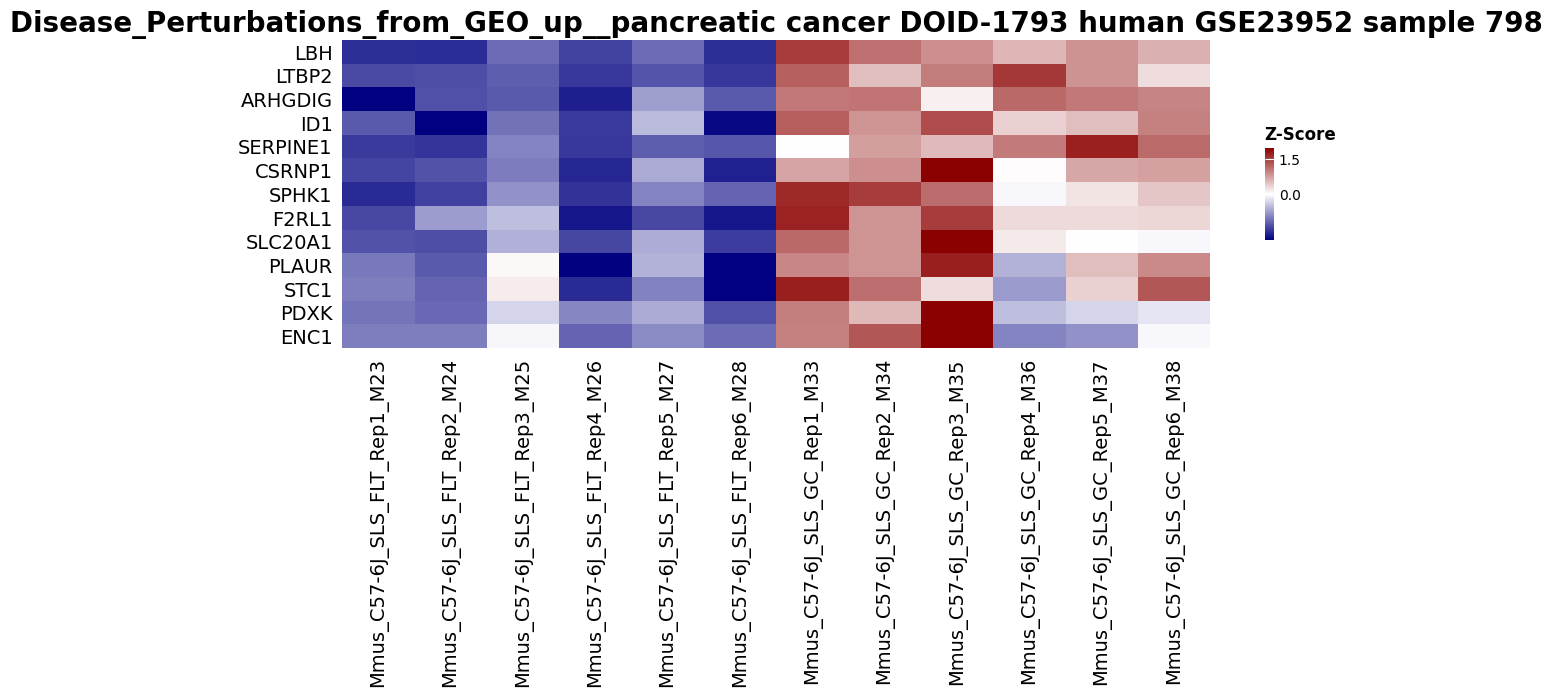

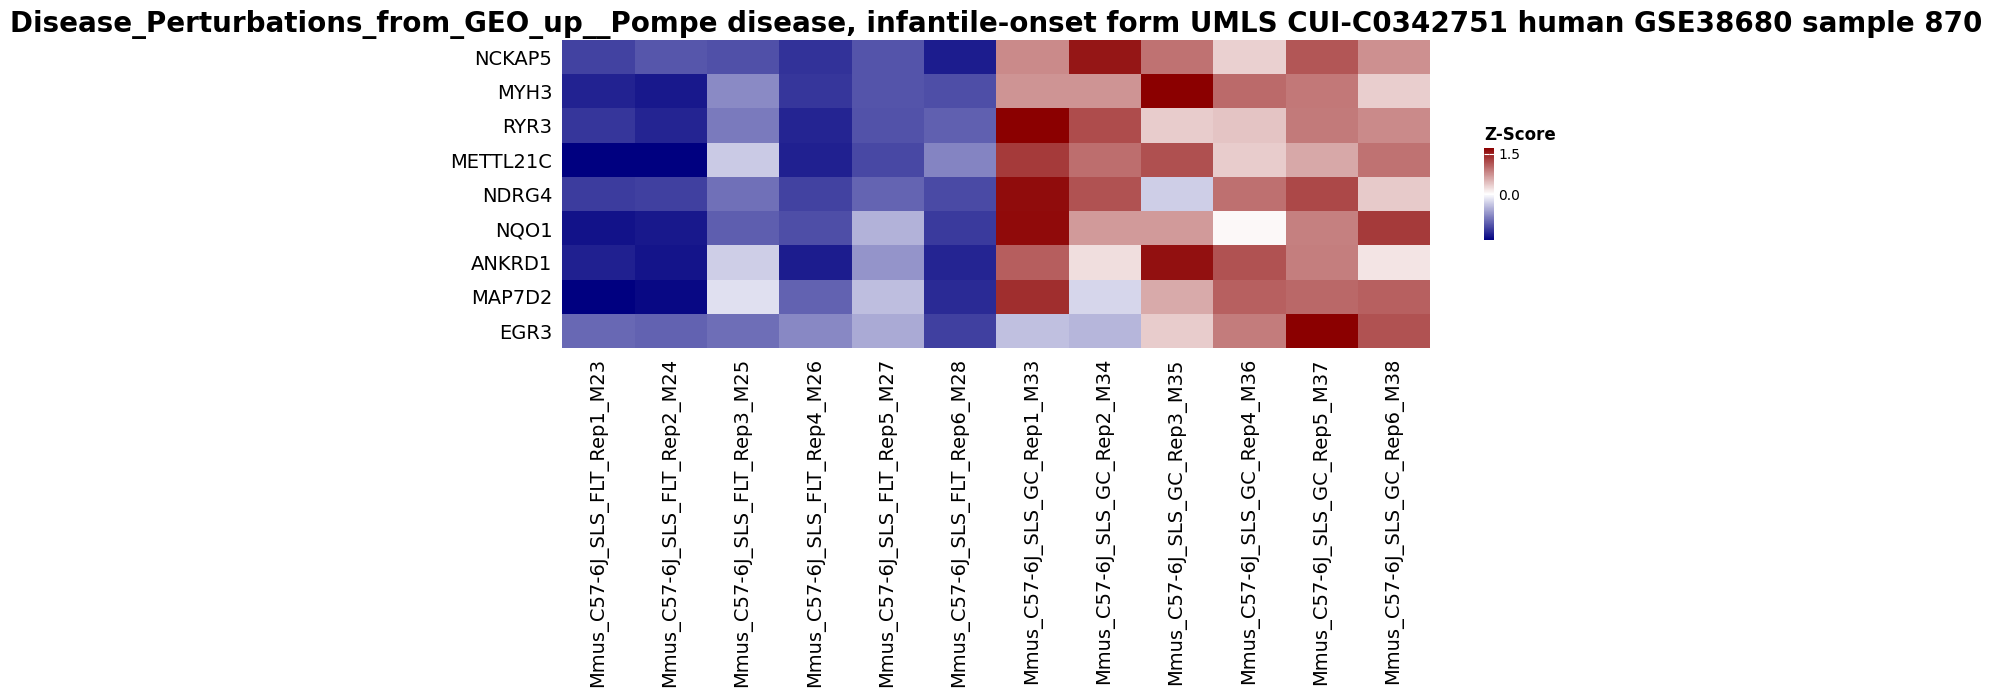

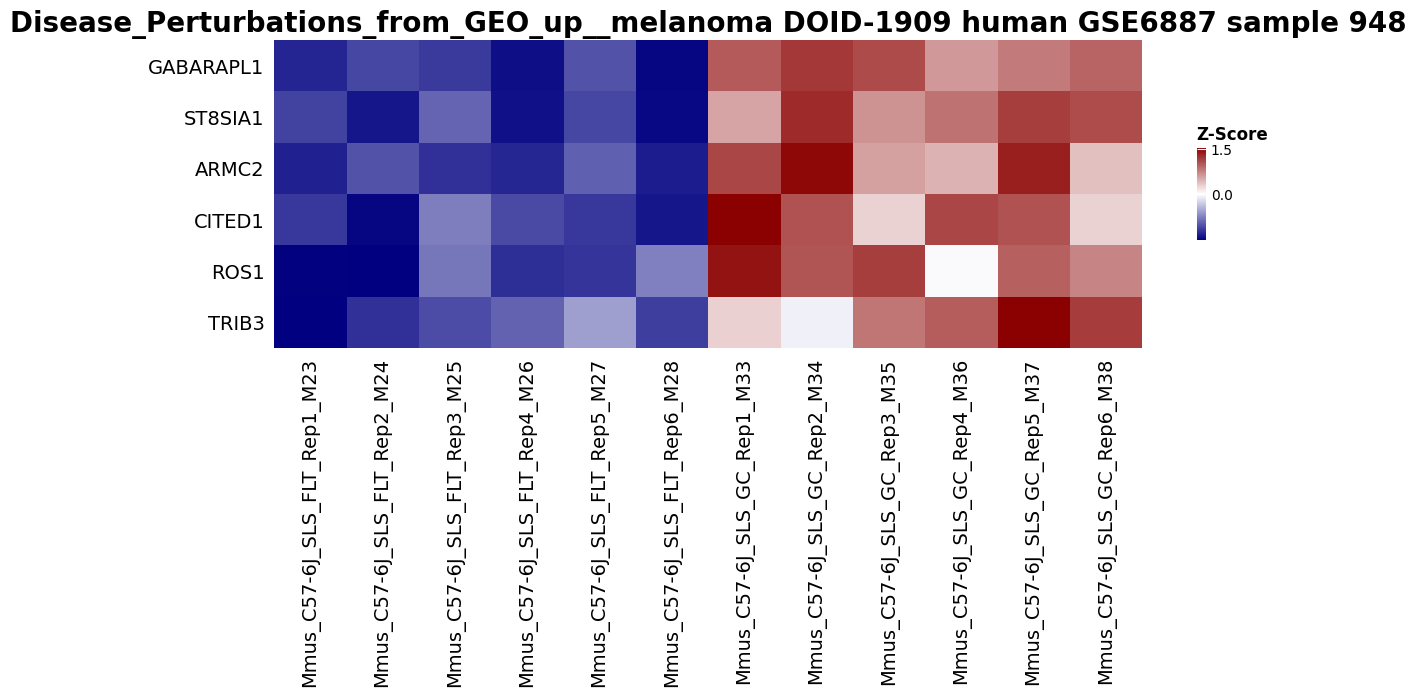

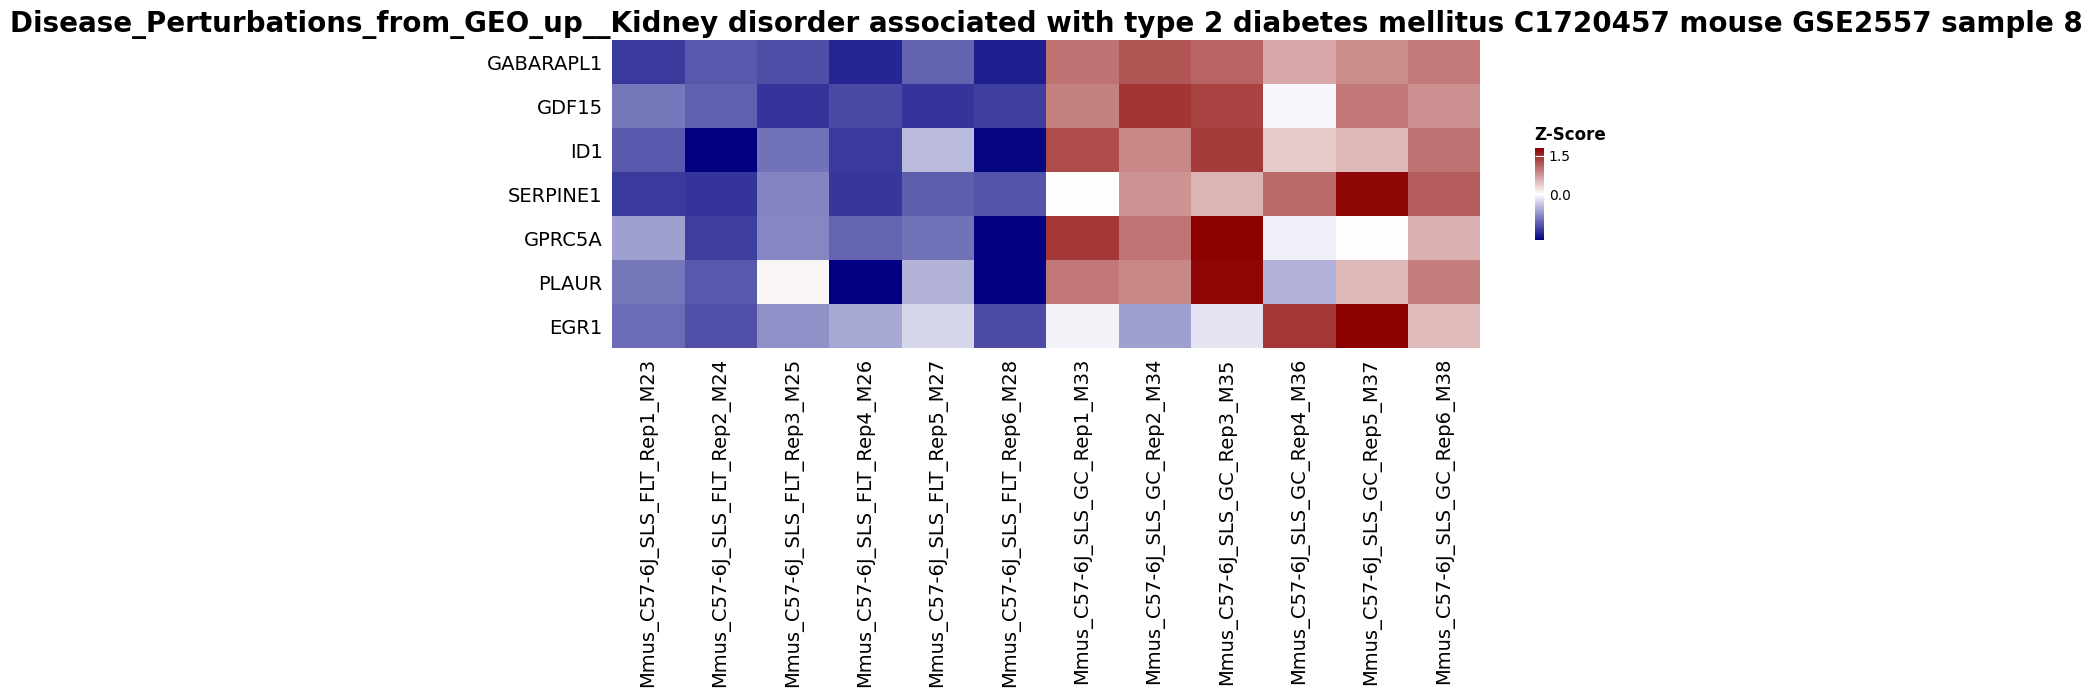

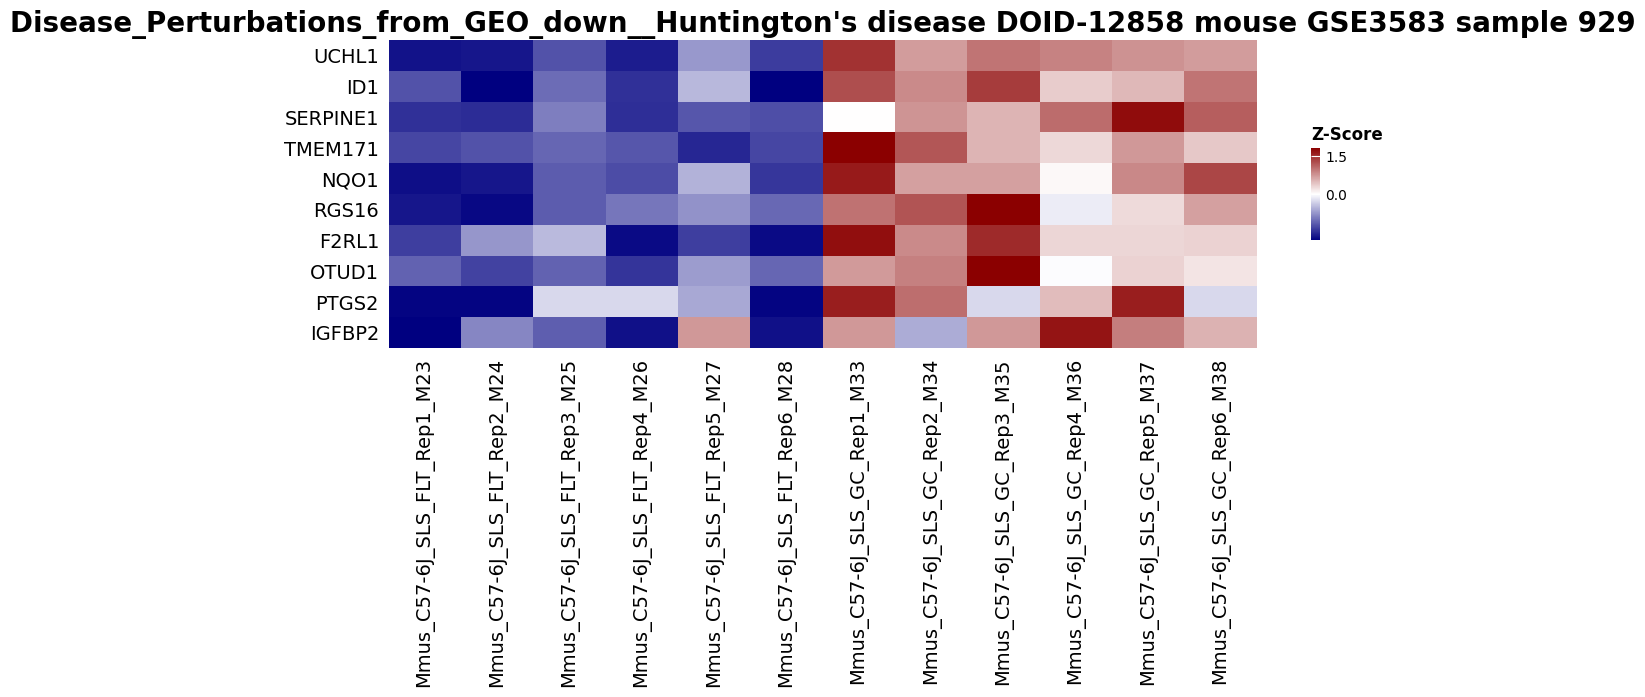

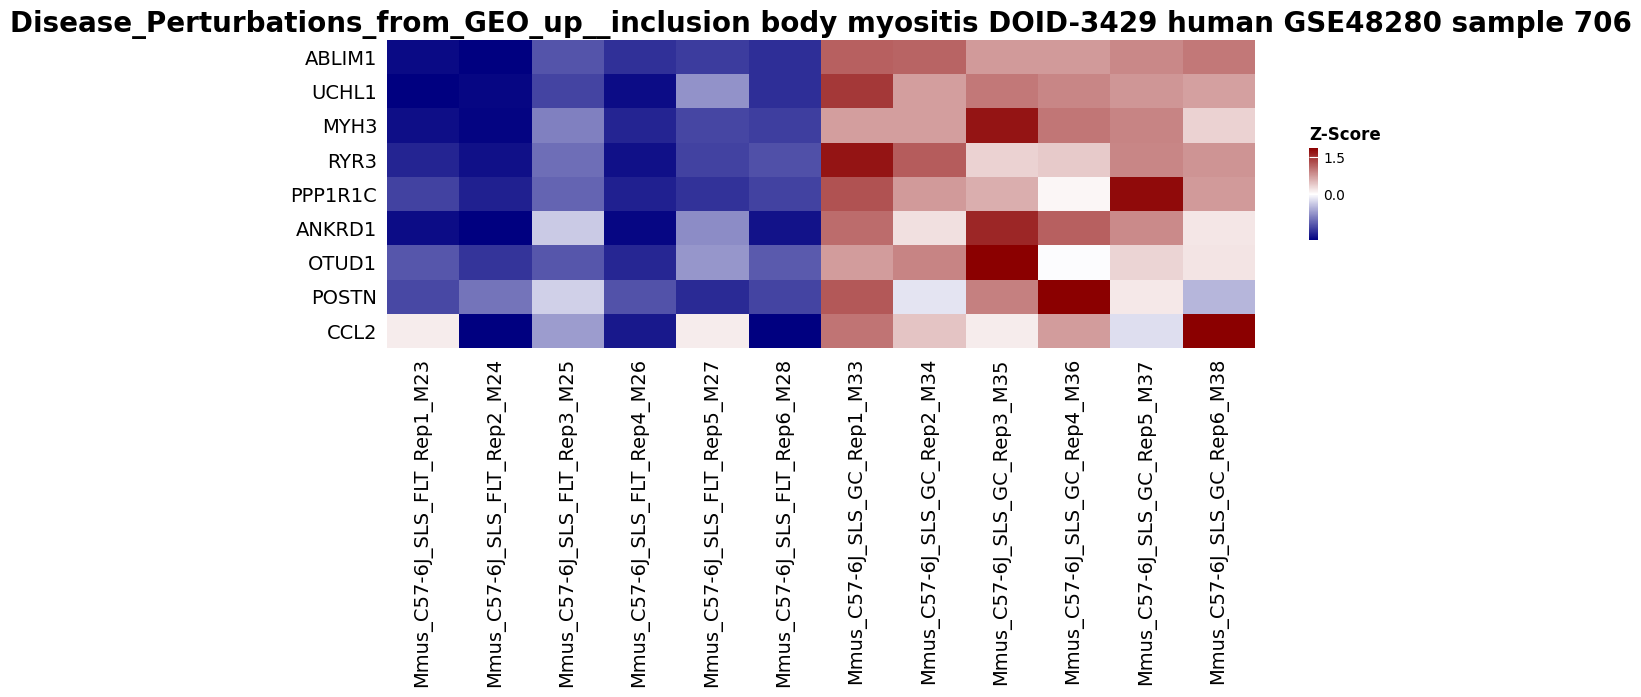

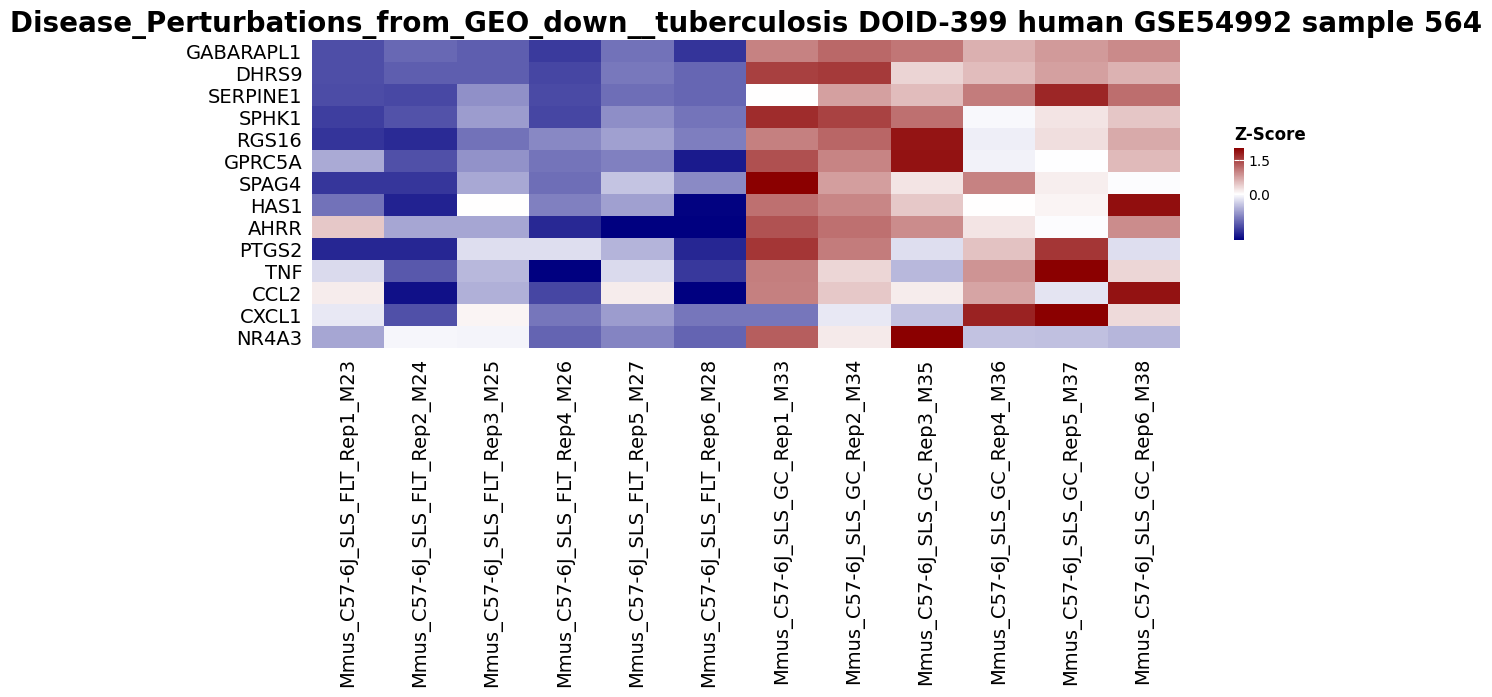

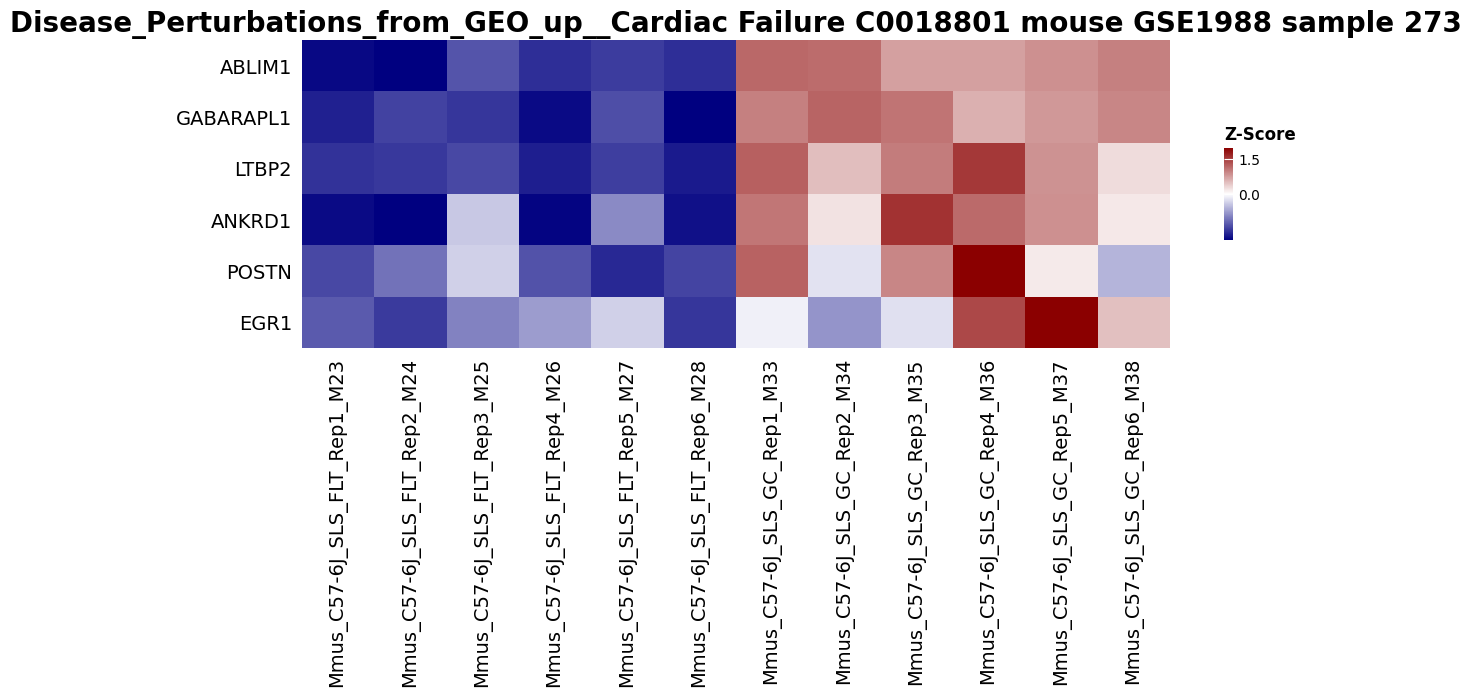

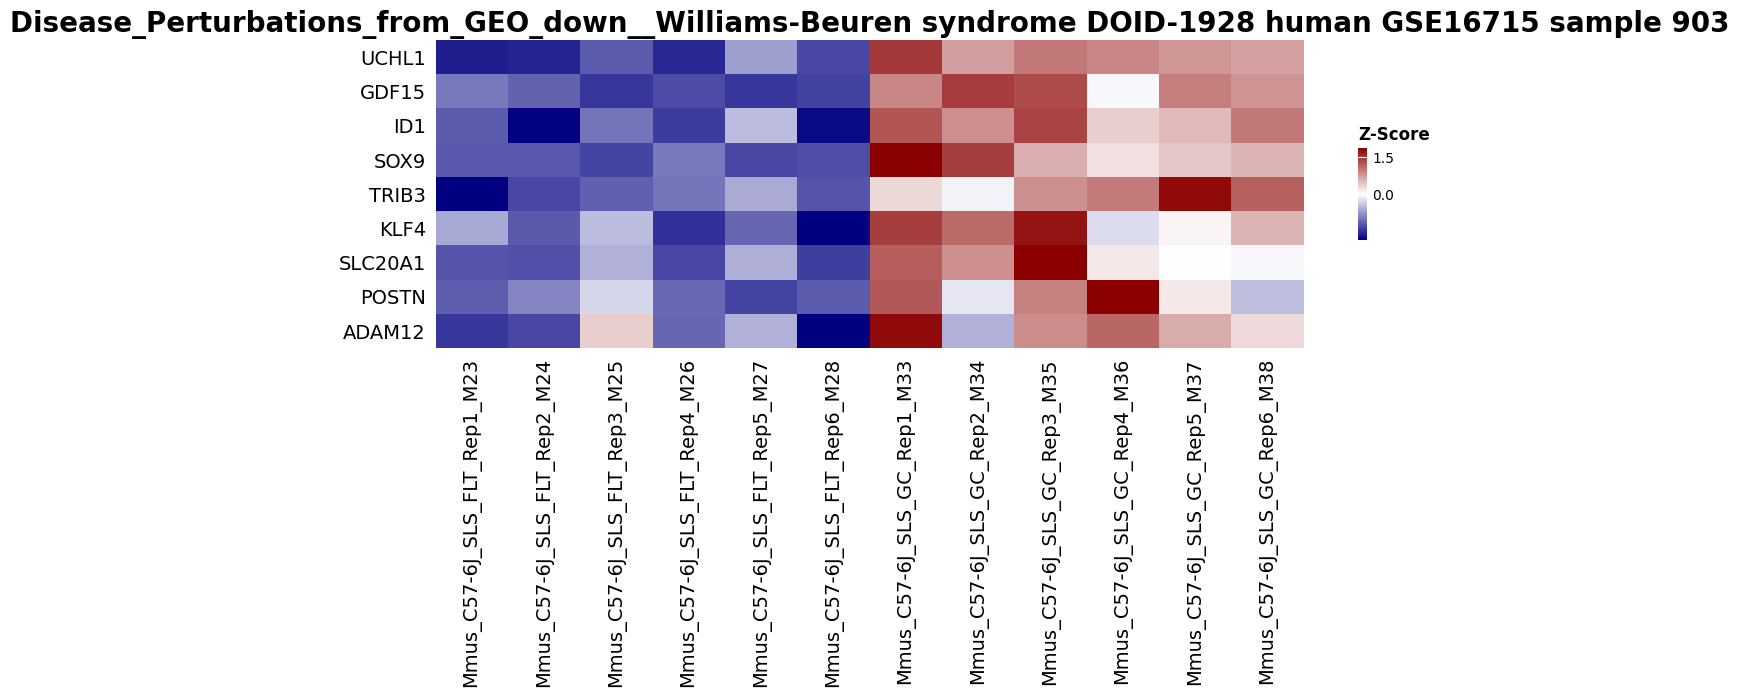

In [26]:
# plot GEO GSEA results in heatmap
from gseapy import heatmap
terms = geo_gsea_results.Term

for i in range(len(geo_gsea_results)):
  genes = geo_gsea_results.Lead_genes[i].split(";")
  ax = heatmap(df = geo_gsea_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4))

# Run over-representation analysis

We will use Enrichr from the `gseapy` Python package to perform over-representation analysis. You can learn more about Enrichr [here](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-128).

In [27]:
# get list of all available gene sets to query
list_of_gene_sets=gp.get_library_name(organism='Mouse')
print('number of gene sets to analyze: ', len(list_of_gene_sets))
print(list_of_gene_sets[:10])

number of gene sets to analyze:  217
['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021']


In [28]:
# print libraries out
mouse_libraries = gp.get_library_name(organism='Mouse')
print('all libraries: ', mouse_libraries)


all libraries:  ['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'COMPARTMENTS_Curated_2025', 'COMPARTMENTS_Experimental_2025', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_201

We are only going to look at a few of those gene sets, but you should feel free to add more gene sets from the list above to the list below. You can learn more about these gene sets [here](https://maayanlab.cloud/Enrichr/#libraries).

In [29]:
# verify the gene sets we're exploring are still part of the supported libraries
# if one is not available, terminate the notebook!
available_gene_sets = list()

for gene_set in ['GO_Molecular_Function_2025', \
                 'GO_Biological_Process_2025', \
                 'GO_Cellular_Component_2025', \
                 'Disease_Perturbations_from_GEO_down', \
                 'Disease_Perturbations_from_GEO_up']:
  if gene_set not in list_of_gene_sets:
    print('gene set not found!:', gene_set)
    raise Exception("STOP! remove this gene set from the gene_set list above as it appears to be unavailable")
  else:
    print('gene set found: ', gene_set)
    available_gene_sets.append(gene_set)

gene set found:  GO_Molecular_Function_2025
gene set found:  GO_Biological_Process_2025
gene set found:  GO_Cellular_Component_2025
gene set found:  Disease_Perturbations_from_GEO_down
gene set found:  Disease_Perturbations_from_GEO_up


In [30]:
# define dictionary to hold results and enrichR object to hold enrichR data
enrichr_results = {}
enrichr = {}

**NOTE**

The calls to the online Enrichr Web Service may fail (it's a free Web service that has been known to periodically fail). If they do fail, you can copy the list of differentially expressed genes into your favorite editor (like MS Word or textedit or Google Docs) and create a list such as the following by removing the "'", "[", "]" characters from the list. Then use online pathway and gene set enrichment tools such as [DAVID](https://davidbioinformatics.nih.gov/summary.jsp), [MSigDB](https://www.gsea-msigdb.org/gsea/login.jsp), and [ShinyGO](https://bioinformatics.sdstate.edu/go/).



In [31]:
# Get GO results
# print the top 10
gene_sets = ['GO_Molecular_Function_2025','GO_Cellular_Component_2025', 'GO_Biological_Process_2025']
enrichr_results['GO'], enrichr['GO'] = run_run_ora(deg_gene_symbols, background_gene_symbols, available_gene_sets, gene_sets)
enrichr_results['GO'].head(10)


gene set found:  GO_Molecular_Function_2025
gene set found:  GO_Cellular_Component_2025
gene set found:  GO_Biological_Process_2025


,Term,Genes,Adjusted P-value,Combined Score
150,Chylomicron (GO:0042627),APOC1;APOC3;APOB,0.004358,643.809620
151,Triglyceride-Rich Plasma Lipoprotein Particle ...,APOC1;APOC3;APOB,0.005552,269.235384
152,Very-Low-Density Lipoprotein Particle (GO:0034...,APOC1;APOC3;APOB,0.005552,269.235384
153,Intermediate Filament (GO:0005882),KRT71;KRT14;KRT79;PKP1;KRT5,0.005552,80.517176
154,Keratin Filament (GO:0045095),KRT71;KRT14;KRT79;KRT5,0.005552,120.850479
155,Desmosome (GO:0030057),POF1B;PKP1;DSC3,0.012344,146.341568
156,Cell-Cell Junction (GO:0005911),COL17A1;IGSF21;POF1B;TRIM29;PKP1;FAT2;AQP3;APO...,0.015306,26.437559
259,Intermediate Filament Organization (GO:0045109),KRT71;KRT28;KRT15;KRT14;TCHH;KRT79;PKP1;KRT5,0.000088,263.245383
260,Epithelial Cell Differentiation (GO:0030855),DLX3;CITED1;KRT28;DHRS9;KRT15;GSTA1;KRT14;OVOL1,0.004502,96.422152
261,Epithelium Development (GO:0060429),NDRG4;DLX3;KRT28;DHRS9;KRT15;GSTA1;KRT14;SOX9,0.008968,69.777666


The output includes each of the gene ontologies that are over-represented by your list of significantly differentially expressed genes. The ORA output is sorted by adjusted p-value.

Each over-represented gene set includes your genes which belong to that gene set, along with the adjusted p-value representing the significance of the enrichment. Recall that, in DGEA where we are conducting the same statistical test thousands of times, we needed to adjust the p-value to account for the inflated number of false positives due to multiple testing. Similarly, here we are also conducting the same statistical test thousands of times -- once per gene set. So we also need to adjust the p-value accordingly. You can learn more about how p-values are calculated and adjusted in this [YouTube video](https://www.youtube.com/watch?v=EF94wPaqXM0).

You can learn more about GO (gene ontology) and the 3 aspects Molecular Function (MF), Cellular Component (CC), and Biological Process (BP) in [this document](https://geneontology.org/docs/ontology-documentation/).

In [32]:
# get disease perturbations for down-regulated GEO signatures
# print the top 10
gene_sets = ['Disease_Perturbations_from_GEO_down']
enrichr_results['GEO_down'], enrichr['GEO_down'] = run_run_ora(deg_gene_symbols, background_gene_symbols, available_gene_sets, gene_sets)
enrichr_results['GEO_down'].head(10)


gene set found:  Disease_Perturbations_from_GEO_down


,Term,Genes,Adjusted P-value,Combined Score
0,Spinal Muscular Atrophy C0026847 mouse GSE1059...,SLC13A1;MIOX;SPINK1;SLC34A1;AQP3;HSD11B2;AADAC...,0.000028,135.056524
1,Malignant Melanoma C0025202 human GSE4587 samp...,DSP;CDH3;TRIM29;KRT15;KRT14;KRT5;S100A14;AQP3;...,0.002096,69.857279
2,nephrosclerosis DOID-11664 human GSE20602 samp...,DSP;HSD11B2;GDF15;SLC34A1;PAH;ALB;SOX9;GC;SLC2...,0.002096,72.935448
3,"Hepatitis, Autoimmune C0241910 mouse GSE867 sa...",ARG1;ALB;APOC1;ALDOB;APOB;GC;FBP1;GCK;GSTM6;CY...,0.002235,67.741861
4,nemaline myopathy DOID-3191 mouse GSE3384 samp...,ARG1;PAH;ALB;APOC1;ALDOB;GC;SLC27A2;FBP1;CYP2D26,0.016171,45.834735
5,Eczema DOID-3310 human GSE32924 sample 509,KRT71;SPINK1;PLN;POF1B;AADAC;ARG1;TCHH;PKP1;SE...,0.019399,36.909842
6,atherosclerosis DOID-1936 mouse GSE19286 sampl...,NDRG4;ARG1;PAH;ALB;APOC1;APOC3;GC;SLC27A2;ASPRV1,0.019399,39.300156
7,Breast Cancer C0006142 human GSE3744 sample 24,COL17A1;TFAP2B;CDH3;CITED1;TRIM29;KRT15;KRT14;...,0.019399,29.956480
8,cervical cancer DOID-4362 human GSE9750 sample...,DSP;TRIM29;KRT15;KRT14;DEFB1;KRT5;S100A14;PTGD...,0.019399,37.591381
9,atopic dermatitis DOID-3310 human GSE32924 sam...,COL17A1;KRT71;PLN;POF1B;AADAC;KRT79;PKP1;SERPI...,0.020014,32.969855


Here we see 16 different gene sets over-represented by our list of differentially expressed genes. All adjusted p-values are necessarily less than 0.05 because the alpha threshold of significance in our `run_ora()` method defined it as such. If we were to relax this threshold, we should anticipate finding more over-represented gene sets. Similarly, if we were to lower this threshold, we should anticipate finding fewer over-represented gene sets.



In [33]:
# examine the full term and list of genes for the first enriched gene set in the GEO_down library.
print('GEO_down term: ', enrichr_results['GEO_down'].iloc[0]['Term'])
print('GEO_down genes: ', enrichr_results['GEO_down'].iloc[0]['Genes'])

GEO_down term:  Spinal Muscular Atrophy C0026847 mouse GSE10599 sample 235
GEO_down genes:  SLC13A1;MIOX;SPINK1;SLC34A1;AQP3;HSD11B2;AADAC;PAH;ALB;ALDOB;GC;SLC27A2;FBP1


You can learn more about spinal muscular atrophy in this [research article](https://www.sciencedirect.com/science/article/pii/S0925443914002440). You can learn more about each of the genes using the online NCBI tool called [entrez-gene](https://www.ncbi.nlm.nih.gov/gene/). For example, you can use entrez-gene to learn more about the SLC13A1 gene [here](https://www.ncbi.nlm.nih.gov/gene/55961).

From the list of genes that are over-represented in this gene set, 3 of them are prefixed SLC (solute carrier family of genes). You can learn more about solute carriers in this short [YouTube video](https://www.youtube.com/watch?v=clbvOvQvq5U).

There has been other research that found differentially expressed solute carrier gene expression in spaceflown mice (e.g. [this article](https://pmc.ncbi.nlm.nih.gov/articles/PMC2644242/)).

In [34]:
# get disease perturbations for up-regulated GEO signatures
# print the top 10
gene_sets = ['Disease_Perturbations_from_GEO_up']
enrichr_results['GEO_up'], enrichr['GEO_up'] = run_run_ora(deg_gene_symbols, background_gene_symbols, available_gene_sets, gene_sets)
enrichr_results['GEO_up'].head(10)


gene set found:  Disease_Perturbations_from_GEO_up


,Term,Genes,Adjusted P-value,Combined Score
0,idiopathic pulmonary fibrosis DOID-0050156 hum...,COL17A1;KRT5;AQP3;CDH3;PLN;ARMC3;KRT15;GSTA1;K...,0.000266,86.239506
1,Breast Cancer C0006142 human GSE2155 sample 39,COL17A1;DSP;SERPINE1;KRT5;SERPINB7;CDH3;TRIM29...,0.000266,78.471276
2,lung squamous cell carcinoma DOID-3907 human G...,TFAP2A;COL17A1;WDR72;KRT5;SERPINB7;CDH3;POF1B;...,0.000911,64.299077
3,Squamous cell carcinoma of lung C0149782 human...,COL17A1;DSP;CDH3;TRIM29;ESRP1;KRT15;KRT14;PKP1...,0.001473,66.459501
4,idiopathic pulmonary fibrosis DOID-0050156 hum...,CDH3;DHRS9;ARMC3;KRT15;KRT14;APOC1;KRT5;PTGDS;...,0.001516,56.484025
5,skin squamous cell carcinoma DOID-3151 human G...,DSP;HAL;CDH3;ARG1;KRT14;PKP1;KRT5;S100A14;AQP3...,0.001516,67.741861
6,adenosquamous cell lung carcinoma DOID-4829 hu...,TFAP2A;COL17A1;SPINK1;KRT15;KRT14;PKP1;WDR72;K...,0.002078,55.316333
7,Hepatic lipidosis C0015695 mouse GSE5538 sampl...,UROC1;ARG1;PAH;ALB;APOC1;APOC3;ALDOB;APOB;GC;S...,0.003737,47.470693
8,cystic fibrosis DOID-1485 mouse GSE3100 sample...,ARG1;TRIM29;KRT15;KRT14;KRT79;PKP1;KRT5;S100A1...,0.007091,40.114875
9,atopic dermatitis skin DOID-3310 human GSE3292...,COL17A1;KRT71;PLN;POF1B;AADAC;KRT79;PKP1;SERPI...,0.019322,32.767805


In [35]:
# examine the full term and list of genes for the first enriched gene set of the GEO_up library
print('GEO_up term: ', enrichr_results['GEO_up'].iloc[0]['Term'])
print('GEO_up genes: ', enrichr_results['GEO_up'].iloc[0]['Genes'])

GEO_up term:  idiopathic pulmonary fibrosis DOID-0050156 human GSE24206 sample 872
GEO_up genes:  COL17A1;KRT5;AQP3;CDH3;PLN;ARMC3;KRT15;GSTA1;KRT14;FAT2;PTGDS;SLC27A2;FBP1;DSC3


This particular gene set (idiopathic pulmonary fibrosis) doesn't seem to have much in common with our tissue (soleus muscle) or the condition of spaceflight. Sometimes this happens. The p-value represents the probability of making this observation (identifying disease perturbation gene set enrichment) by random chance. This probability / p-value is never 0 and therefore is one reason you may well observe false positives. Another reason is that gene sets have overlapping genes because genes may participate in multiple unrelated biological and molecular pathways.

Even so, there may be an association between the over-represented gene set and the phenotype you're observing. In this particular case, pulmonary fibrosis may lead to musculoskeletal pathology (see this [article](https://pmc.ncbi.nlm.nih.gov/articles/PMC10851557/)) which is itself a hallmark risk of spaceflight for vertebrate animals such as humans and mice. We may then speculate that genes which differentially respond to the effects of pulmonary fibrosis may also respond to the effects of spaceflight.

So after getting these results, you may need to further filter out the gene sets that do not correspond to the tissue and phenotype in your experiment. How to interpret ORA results is discussed in the [GSEA documentation](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html).

In general, it's important to note that the results from GSEA and ORA identify genes which are *associated* with a disease or molecular or biological process, not necessarily *causal* of any outcomes. Combining multiple forms of this type of analysis can help refine your results as discussed in [this YouTube video](https://www.youtube.com/watch?v=t90x9TlW6Y0). As such, GSEA and ORA are hypothesis generators and you need to be careful with how you interpret the results.

In [36]:
# save results to file
for db in enrichr_results.keys():
  if not enrichr_results[db] is None:
    enrichr_results[db].to_csv(GSEA_DIR + '/ora_results_' + db + '_' + OSD_DATASET + '.csv', index=None)

# Plot ORA results
A GO plot is used to visualize the enriched Gene Ontology (GO) terms generated from the previous steps of the notebook. The four plots generated below represent two of the same results in two slightly visual formats (dot plot versus lollipop plot): In both the dot plot and the lollipop plot, the size of the marker represents the significance of the over-representation (based on the adjusted p-value), while the position along the x-axis indicates the adjusted p-value itself, with smaller values (higher significance) appearing further to the right.  If a process is "significantly over-represented", this indicates that the set of genes is likely contributing to the differences between ground control and space flight factors.

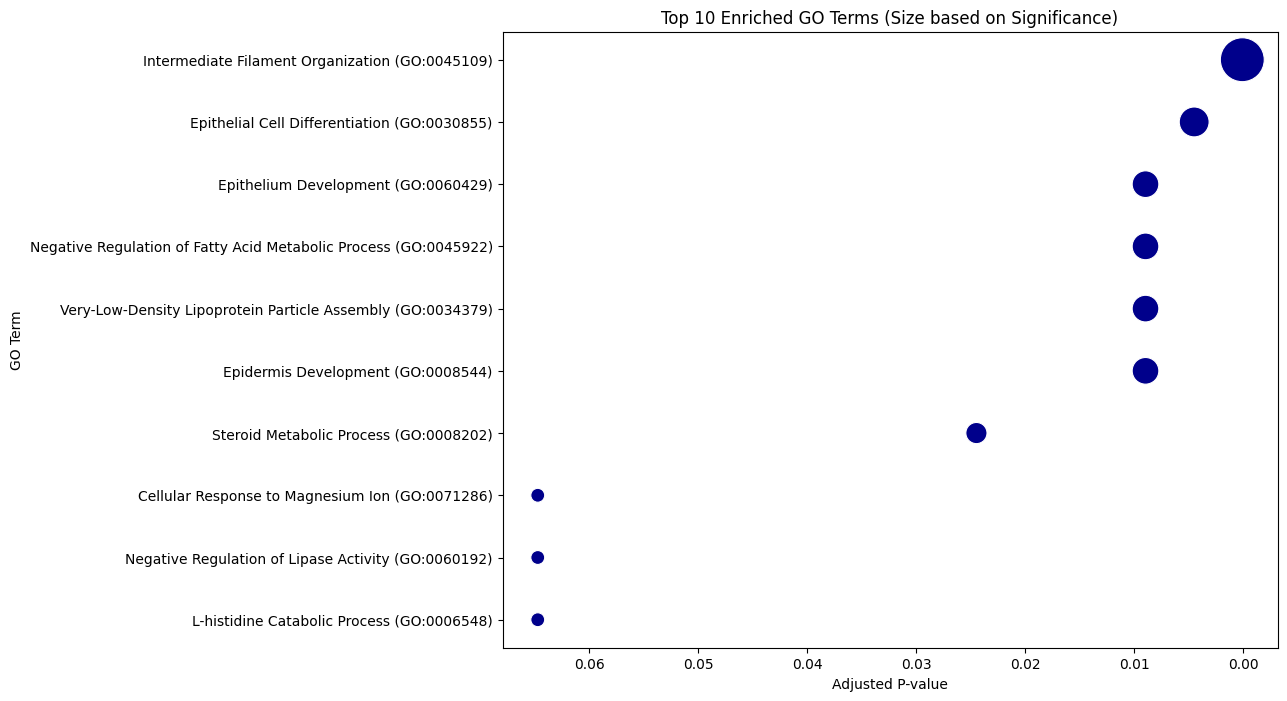

In [37]:
# Plot top GO terms as dot plot with size representing significance

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if not enrichr_results['GO'].empty:
    # Add a column for plotting size based on -log10(Adjusted P-value)
    plot_data = enrichr['GO'].res2d.head(10).copy()
    plot_data['Significance'] = -np.log10(plot_data['Adjusted P-value'])

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Adjusted P-value', y='Term', size='Significance', sizes=(100, 1000), \
                    data=plot_data, color='darkblue', legend=False) # sizes sets the range of dot sizes
    plt.title('Top 10 Enriched GO Terms (Size based on Significance)')
    plt.xlabel('Adjusted P-value')
    plt.ylabel('GO Term')
    plt.gca().invert_xaxis() # Invert x-axis to show smaller p-values at the top
    plt.show()
else:
    print("No significant GO terms found to plot.")

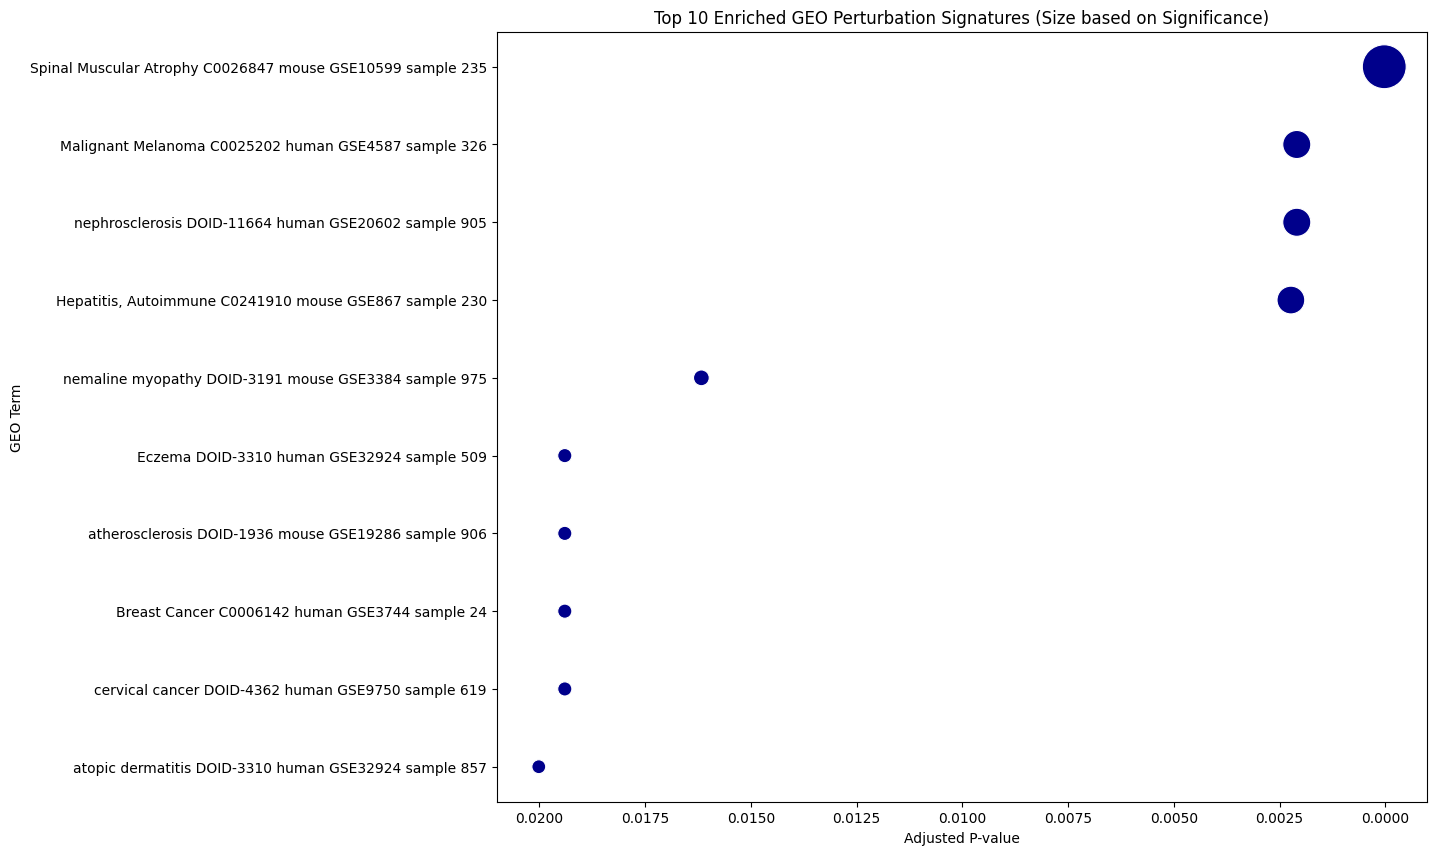

In [38]:
# Plot top GEO up and down terms as dot plot with size representing significance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

geo_results = pd.concat([enrichr_results['GEO_down'], enrichr_results['GEO_up']], ignore_index=True)

if not geo_results.empty:
    # Add a column for plotting size based on -log10(Adjusted P-value)
    plot_data = enrichr['GEO_down'].res2d.head(10).copy()
    plot_data['Significance'] = -np.log10(plot_data['Adjusted P-value'])

    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='Adjusted P-value', y='Term', size='Significance', sizes=(100, 1000), \
                    data=plot_data, color='darkblue', legend=False) # sizes sets the range of dot sizes
    plt.title('Top 10 Enriched GEO Perturbation Signatures (Size based on Significance)')
    plt.xlabel('Adjusted P-value')
    plt.ylabel('GEO Term')
    plt.gca().invert_xaxis() # Invert x-axis to show smaller p-values at the top
    plt.show()
else:
    print("No significant GEO terms found to plot.")

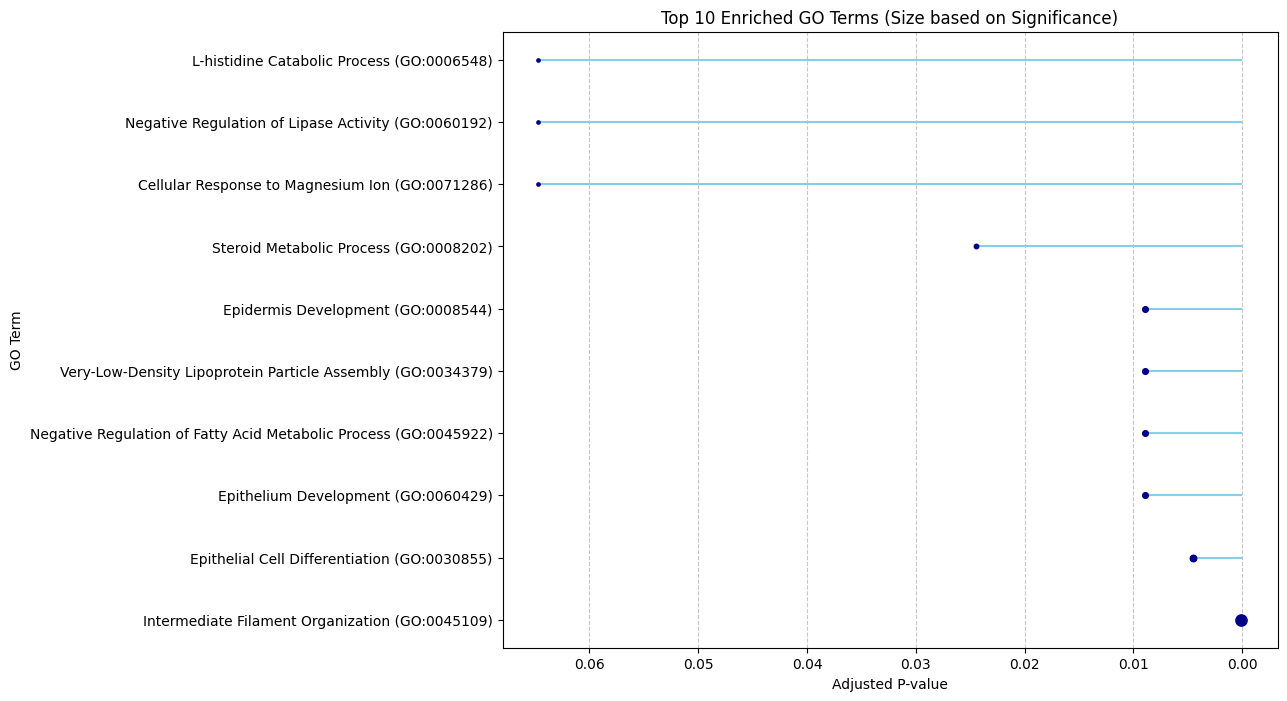

In [39]:
# create lollipop plots for GO ORA results
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if not enrichr_results['GO'].empty:
    '''plot_data = enrichr_results['GO'].head(10).copy()
    plot_data['Significance'] = -np.log10(plot_data['Adjusted P-value'])'''
    plot_data = enrichr['GO'].res2d.head(10).copy()
    plot_data['Significance'] = -np.log10(plot_data['Adjusted P-value'])
    plot_data = plot_data.sort_values('Adjusted P-value', ascending=True) # Sort for better visualization

    plt.figure(figsize=(10, 8))
    plt.hlines(y=plot_data['Term'], xmin=0, xmax=plot_data['Adjusted P-value'], color='skyblue')

    # Plot each point individually with its corresponding marker size
    for index, row in plot_data.iterrows():
        plt.plot(row['Adjusted P-value'], row['Term'], "o", markersize=row['Significance'] * 2, color='darkblue')

    plt.title('Top 10 Enriched GO Terms (Size based on Significance)')
    plt.xlabel('Adjusted P-value')
    plt.ylabel('GO Term')
    plt.gca().invert_xaxis() # Invert x-axis to show smaller p-values at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No significant GO terms found to plot.")

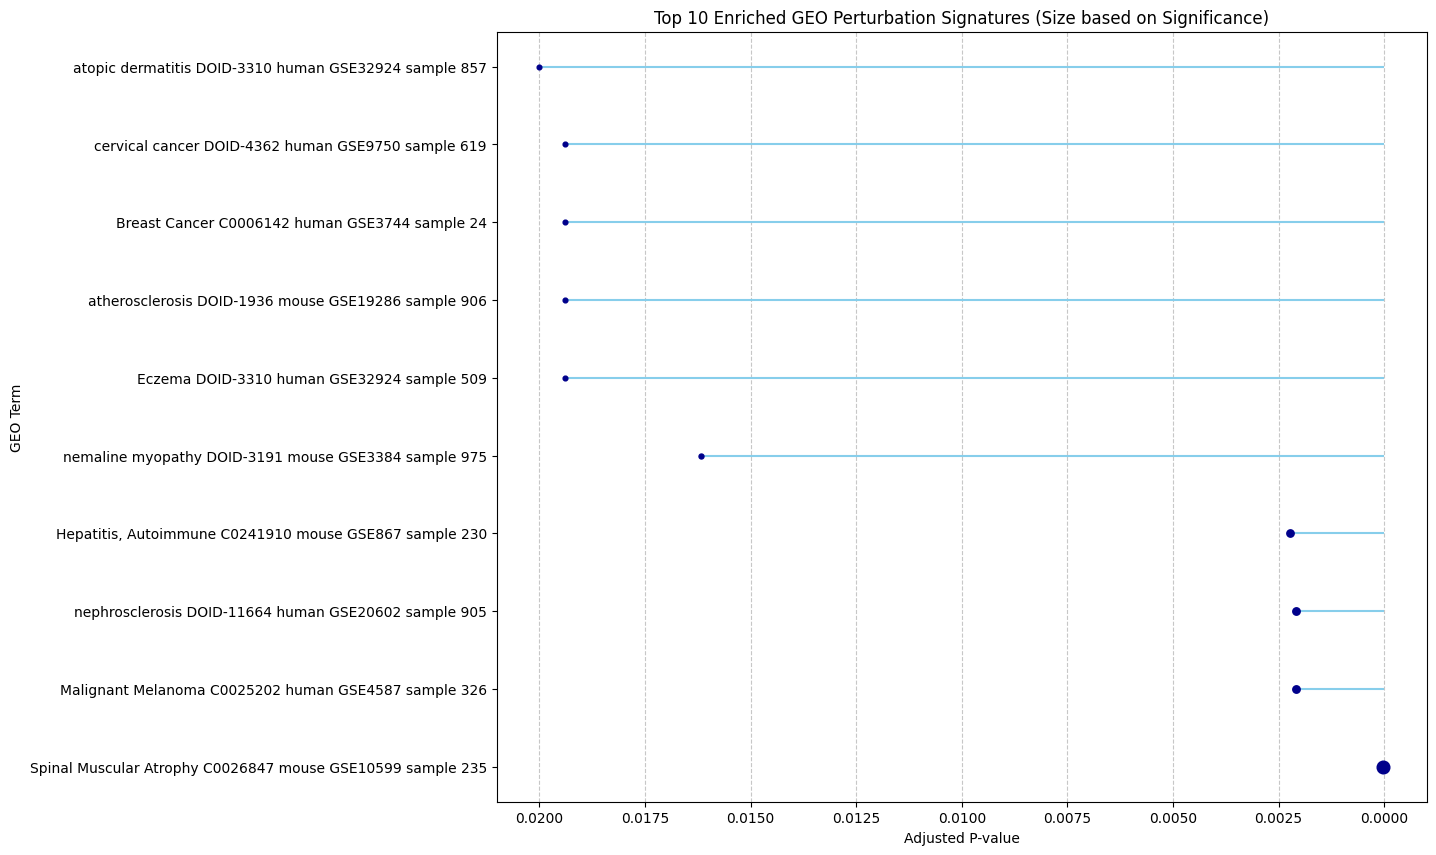

In [40]:
# create lollipop plots for GEO ORA results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

geo_results = pd.concat([enrichr_results['GEO_down'], enrichr_results['GEO_up']], ignore_index=True)

if not geo_results.empty:
    plot_data = geo_results.head(10).copy()
    plot_data['Significance'] = -np.log10(plot_data['Adjusted P-value'])
    plot_data = plot_data.sort_values('Adjusted P-value', ascending=True) # Sort for better visualization

    plt.figure(figsize=(12, 10))
    plt.hlines(y=plot_data['Term'], xmin=0, xmax=plot_data['Adjusted P-value'], color='skyblue')

    # Plot each point individually with its corresponding marker size
    for index, row in plot_data.iterrows():
        plt.plot(row['Adjusted P-value'], row['Term'], "o", markersize=row['Significance'] * 2, color='darkblue')

    plt.title('Top 10 Enriched GEO Perturbation Signatures (Size based on Significance)')
    plt.xlabel('Adjusted P-value')
    plt.ylabel('GEO Term')
    plt.gca().invert_xaxis() # Invert x-axis to show smaller p-values at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No significant GEO terms found to plot.")

# Verify notebook is complete before moving on

In [41]:
# make sure your google drive disk space utilization is still under 15G
# should be about 2.4GB
!du -sh /content/mnt/MyDrive/NASA/GL4HS

2.4G	/content/mnt/MyDrive/NASA/GL4HS


In [42]:
# time the notebook
import datetime
end_time = datetime.datetime.now()
print('notebook end time: ', end_time.strftime('%Y-%m-%d %H:%M:%S'))

print('notebook runtime: ', end_time - start_time)

notebook end time:  2025-07-16 19:50:30
notebook runtime:  0:02:06.568282


In [43]:
# make sure your google drive disk space utilization is still under 15G
# should be about 2.4GB
!du -sh /content/mnt/MyDrive/NASA/GL4HS

2.4G	/content/mnt/MyDrive/NASA/GL4HS
